In [2]:
import numpy as np
import torch.nn as nn
import torch.optim as optim
from shapes import plot_result
from datasets import RectangleDataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from single_rectangle import SimpleModel
# import importlib
# importlib.reload(single_rectangle)
from single_rectangle import plot_performance
# importlib.reload(plot_performance)

In [3]:
data_n_size = 50000
data_xy_size = 8
test_n_size = 10000

batch_size = 8

full_data = RectangleDataset(data_n_size, data_xy_size)
test_data = RectangleDataset(test_n_size, data_xy_size)

train_data, valid_data = train_test_split(full_data, test_size=0.2)

train_dataloader = DataLoader(train_data, batch_size=batch_size,)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size,)
test_dataloader = DataLoader(test_data, batch_size=batch_size,)

40000 10000 10000


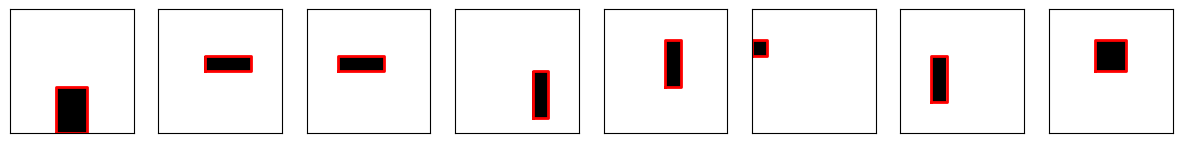

In [5]:
example_data, example_targets = next(iter(train_dataloader))
example_testdata, example_testtarget = next(iter(test_dataloader))

fig, axs = plt.subplots(ncols=batch_size, figsize=(15, 15*batch_size))
for img, res, ax in zip(example_data, example_targets, axs):
    plot_result(np.squeeze(img), res, ax=ax)

print(len(train_data), len(valid_data), len(test_data))

In [14]:
model = SimpleModel(data_xy_size ** 2)

epochs = 50
optimizer = optim.SGD(model.parameters(), lr=0.1)
# optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()

total_loss = []
total_valid_loss = []
total_iou = []
for epoch in range(epochs):
    model.train()

    train_loss, train_error, train_iou = 0.0, 0.0, 0.0
    for data, target in train_dataloader:

        data, target = data.float(), target.float()
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, target)

        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_dataloader)
    total_loss.append(train_loss)

    if epoch % 2 == 0:
        model.eval()
        valid_loss, valid_error, valid_iou = 0.0, 0.0, 0.0

        for data, target in valid_dataloader:
            data, target = data.float(), target.float()

            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()
        valid_loss /= len(valid_dataloader)
        total_valid_loss.append(valid_loss)

        print(f"Epoch {epoch}/{epochs}:\t\t train loss: {train_loss:.5f} \t validation loss: {valid_loss:.5f}")



Epoch 0/50:		 train loss: 0.19517 	 validation loss: 0.01004
Epoch 2/50:		 train loss: 0.03094 	 validation loss: 0.00749
Epoch 4/50:		 train loss: 0.02365 	 validation loss: 0.00535
Epoch 6/50:		 train loss: 0.02026 	 validation loss: 0.00616
Epoch 8/50:		 train loss: 0.01809 	 validation loss: 0.00415
Epoch 10/50:		 train loss: 0.01692 	 validation loss: 0.00302
Epoch 12/50:		 train loss: 0.01577 	 validation loss: 0.00341
Epoch 14/50:		 train loss: 0.01513 	 validation loss: 0.00293
Epoch 16/50:		 train loss: 0.01442 	 validation loss: 0.00145
Epoch 18/50:		 train loss: 0.01394 	 validation loss: 0.00252
Epoch 20/50:		 train loss: 0.01359 	 validation loss: 0.00151
Epoch 22/50:		 train loss: 0.01313 	 validation loss: 0.00129
Epoch 24/50:		 train loss: 0.01283 	 validation loss: 0.00165
Epoch 26/50:		 train loss: 0.01255 	 validation loss: 0.00172
Epoch 28/50:		 train loss: 0.01230 	 validation loss: 0.00173
Epoch 30/50:		 train loss: 0.01216 	 validation loss: 0.00112
Epoch 32/50:	

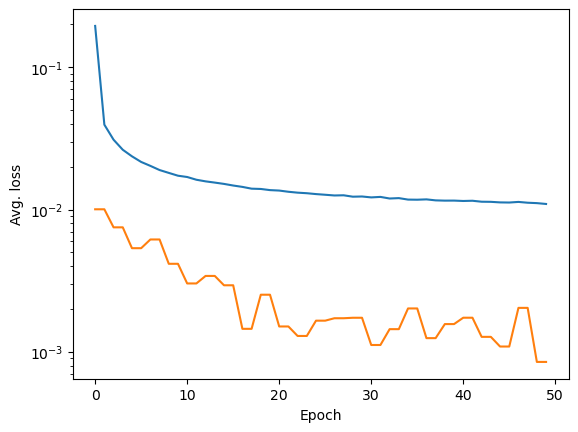

In [20]:
plt.semilogy(total_loss)
plt.semilogy([val for val in total_valid_loss for _ in (0, 1)])
plt.xlabel("Epoch")
plt.ylabel("Avg. loss");

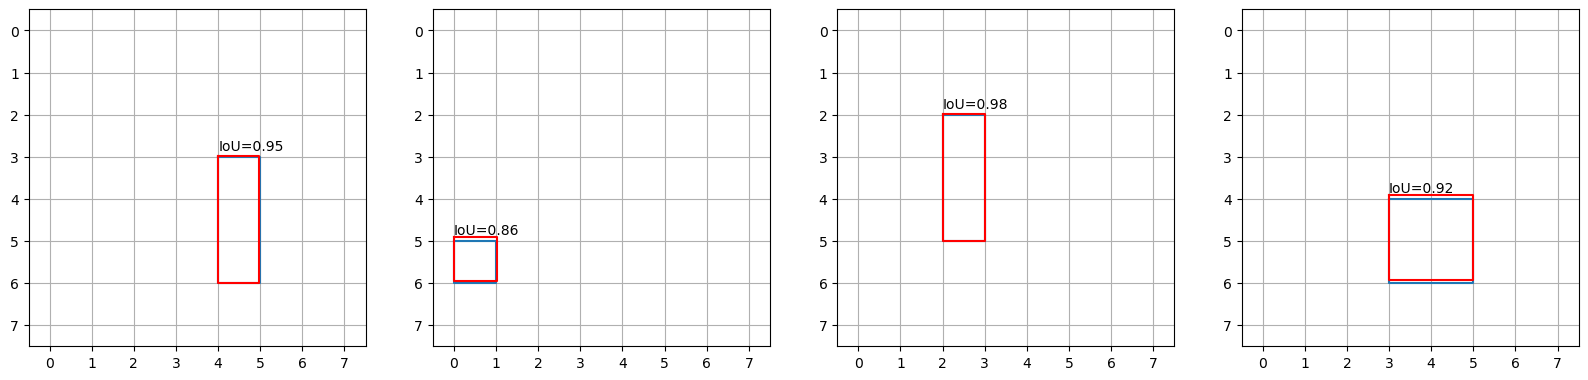

In [28]:
model.eval()
slice = np.s_[4:10]
plot_performance(model, example_data[slice], example_targets[slice], )